# The Carry Trade

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Theory: Carry Trade with Zero-Coupon Bonds

### Zero-Coupon Bond Pricing

A zero-coupon bond with face value $F$ and maturity $T$ has price:
$$P(0,T) = F \cdot Z(0,T)$$

where $Z(0,T)$ is the discount factor. For $F = \$1$, the price equals the discount factor.

### Carry Trade Structure

**Long Position**: Buy $n$-year zero with market value $V_L$
- Face value: $N_L = V_L / Z(0,n)$

**Short Position**: Sell 1-year zero with market value $V_S$
- Face value: $N_S = V_S / Z(0,1)$
- Roll annually: maintain constant $V_S$ market value

**Capital Requirement** with haircut $h$:
$$\text{Capital} = h \cdot V_L + h \cdot V_S$$

### Mark-to-Market and Cash Flows

At time $t$:
- **Long MTM**: $N_L \cdot Z(t, T_L)$
- **Short MTM**: $N_S \cdot Z(t, T_S)$
- **Net Position**: Long MTM - Short MTM

### Short Roll Cash Flow

When 1-year short matures:
1. **Pay face value**: $-N_S$ (cash outflow)
2. **Open new short**: Receive $V_S$ (cash inflow)
3. **Net injection**: $N_S - V_S > 0$ (when rates rise)

The new short face value: $N_S^{new} = V_S / Z(t,1)$

### Return Calculation

$$\text{Period P\&L} = \Delta \text{MTM} - \text{Cash Injection}$$

$$\text{Total Return} = \frac{\sum \text{Period P\&L}}{\text{Initial Capital}}$$

In [2]:
# Load zero-coupon bond data
strips = pd.read_excel('data/famabliss_strips_2025-11-28.xlsx')
strips['date'] = pd.to_datetime(strips['date'])

# Filter to November dates 2020-2025
strips_nov = strips[strips['date'].dt.month == 11].copy()
strips_nov = strips_nov[strips_nov['date'].dt.year.between(2020, 2025)].sort_values('date').reset_index(drop=True)

display(strips_nov)

,date,1,2,3,4,5
0,2020-11-30,0.998839,0.997047,0.994464,0.988809,0.981515
1,2021-11-30,0.997523,0.988614,0.974796,0.958322,0.943772
2,2022-11-30,0.954375,0.918220,0.887608,0.857356,0.830593
3,2023-11-30,0.951080,0.911951,0.876957,0.842191,0.809378
4,2024-11-29,0.959187,0.920923,0.885440,0.850418,0.817795
5,2025-11-28,0.964936,0.932866,0.900919,0.868240,0.836057


## 1.1 Carry Trade Setup (November 2020)

In [3]:
# Initial parameters
initial_capital = 4_000_000
market_value_long = 100_000_000
market_value_short = 100_000_000
haircut = 0.02

# Nov 2020 prices
Z_5y_2020 = strips_nov.loc[0, 5]
Z_1y_2020 = strips_nov.loc[0, 1]

# Calculate face values
face_long = market_value_long / Z_5y_2020
face_short_initial = market_value_short / Z_1y_2020

print(f"5Y Zero Price: {Z_5y_2020:.6f}")
print(f"1Y Zero Price: {Z_1y_2020:.6f}")
print(f"Long Face Value:  ${face_long:,.0f}")
print(f"Short Face Value: ${face_short_initial:,.0f}")
print(f"Capital Required: ${initial_capital:,.0f}")

5Y Zero Price: 0.981515
1Y Zero Price: 0.998839
Long Face Value:  $101,883,281
Short Face Value: $100,116,228
Capital Required: $4,000,000


## Year-by-Year P&L Calculation

### Methodology

For each year:
1. Mark long position to market using appropriate discount factor
2. Mark short position to market (if active)
3. Calculate MTM change from previous period
4. Account for cash injection when rolling short
5. Compute period P&L = MTM change - cash injection

In [4]:
# Year-by-year P&L calculation
pnl_data = []
current_short_face = face_short_initial

for i in range(len(strips_nov)):
    year = strips_nov.loc[i, 'date'].year
    years_remaining = 2025 - year
    
    # Long position MTM
    if years_remaining > 0:
        Z_long = strips_nov.loc[i, years_remaining]
        long_mtm = face_long * Z_long
    else:
        Z_long = 1.0
        long_mtm = face_long
    
    # Short position MTM and roll
    cash_injection = 0
    if year <= 2023:
        Z_short = strips_nov.loc[i, 1]
        short_mtm = current_short_face * Z_short
        
        if year >= 2021:  # Short matures, must roll
            cash_outflow = current_short_face
            new_short_proceeds = market_value_short
            current_short_face = market_value_short / Z_short
            cash_injection = cash_outflow - new_short_proceeds
    
    elif year == 2024:  # Close short, no new position
        Z_short = 0
        short_mtm = 0
        cash_injection = current_short_face
        current_short_face = 0
    
    else:  # 2025 - no short
        Z_short = 0
        short_mtm = 0
    
    net_mtm = long_mtm - short_mtm
    
    pnl_data.append({
        'year': year,
        'years_to_maturity': years_remaining,
        'Z_long': Z_long,
        'Z_short': Z_short,
        'long_mtm': long_mtm,
        'short_mtm': short_mtm,
        'net_mtm': net_mtm,
        'cash_injection': cash_injection
    })

pnl_df = pd.DataFrame(pnl_data)
pnl_df['mtm_pnl'] = pnl_df['net_mtm'].diff().fillna(0)
pnl_df['period_pnl'] = pnl_df['mtm_pnl'] - pnl_df['cash_injection']
pnl_df['cumulative_pnl'] = pnl_df['period_pnl'].cumsum()

display(pnl_df[['year', 'years_to_maturity', 'long_mtm', 'short_mtm', 
                 'net_mtm', 'cash_injection', 'period_pnl', 'cumulative_pnl']])

,year,years_to_maturity,long_mtm,short_mtm,net_mtm,cash_injection,period_pnl,cumulative_pnl
0,2020,5,1.000000e+08,1.000000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2021,4,9.763703e+07,9.986821e+07,-2.231180e+06,1.162275e+05,-2.347408e+06,-2.347408e+06
2,2022,3,9.043237e+07,9.567452e+07,-5.242144e+06,2.483473e+05,-3.259311e+06,-5.606719e+06
3,2023,2,9.291255e+07,9.965473e+07,-6.742187e+06,4.780616e+06,-6.280659e+06,-1.188738e+07
4,2024,1,9.772511e+07,0.000000e+00,9.772511e+07,1.051436e+08,-6.763428e+05,-1.256372e+07
5,2025,0,1.018833e+08,0.000000e+00,1.018833e+08,0.000000e+00,4.158168e+06,-8.405552e+06


## Total Return Analysis

In [5]:
# Calculate returns
final_pnl = pnl_df['cumulative_pnl'].iloc[-1]
total_capital_invested = initial_capital + pnl_df['cash_injection'].sum()
return_on_initial = final_pnl / initial_capital
annualized_return = (1 + return_on_initial)**(1/5) - 1

print(f"Initial Capital:          ${initial_capital:,.0f}")
print(f"Total Cash Injections:    ${pnl_df['cash_injection'].sum():,.0f}")
print(f"Final P&L:                ${final_pnl:,.0f}")
print(f"Return on Initial:        {return_on_initial:.2%}")
print(f"Annualized Return:        {annualized_return:.2%}")

Initial Capital:          $4,000,000
Total Cash Injections:    $110,288,833
Final P&L:                $-8,405,552
Return on Initial:        -210.14%
Annualized Return:        nan%


C:\Users\15126\AppData\Local\Temp\ipykernel_34820\3402581360.py:5: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1 + return_on_initial)**(1/5) - 1


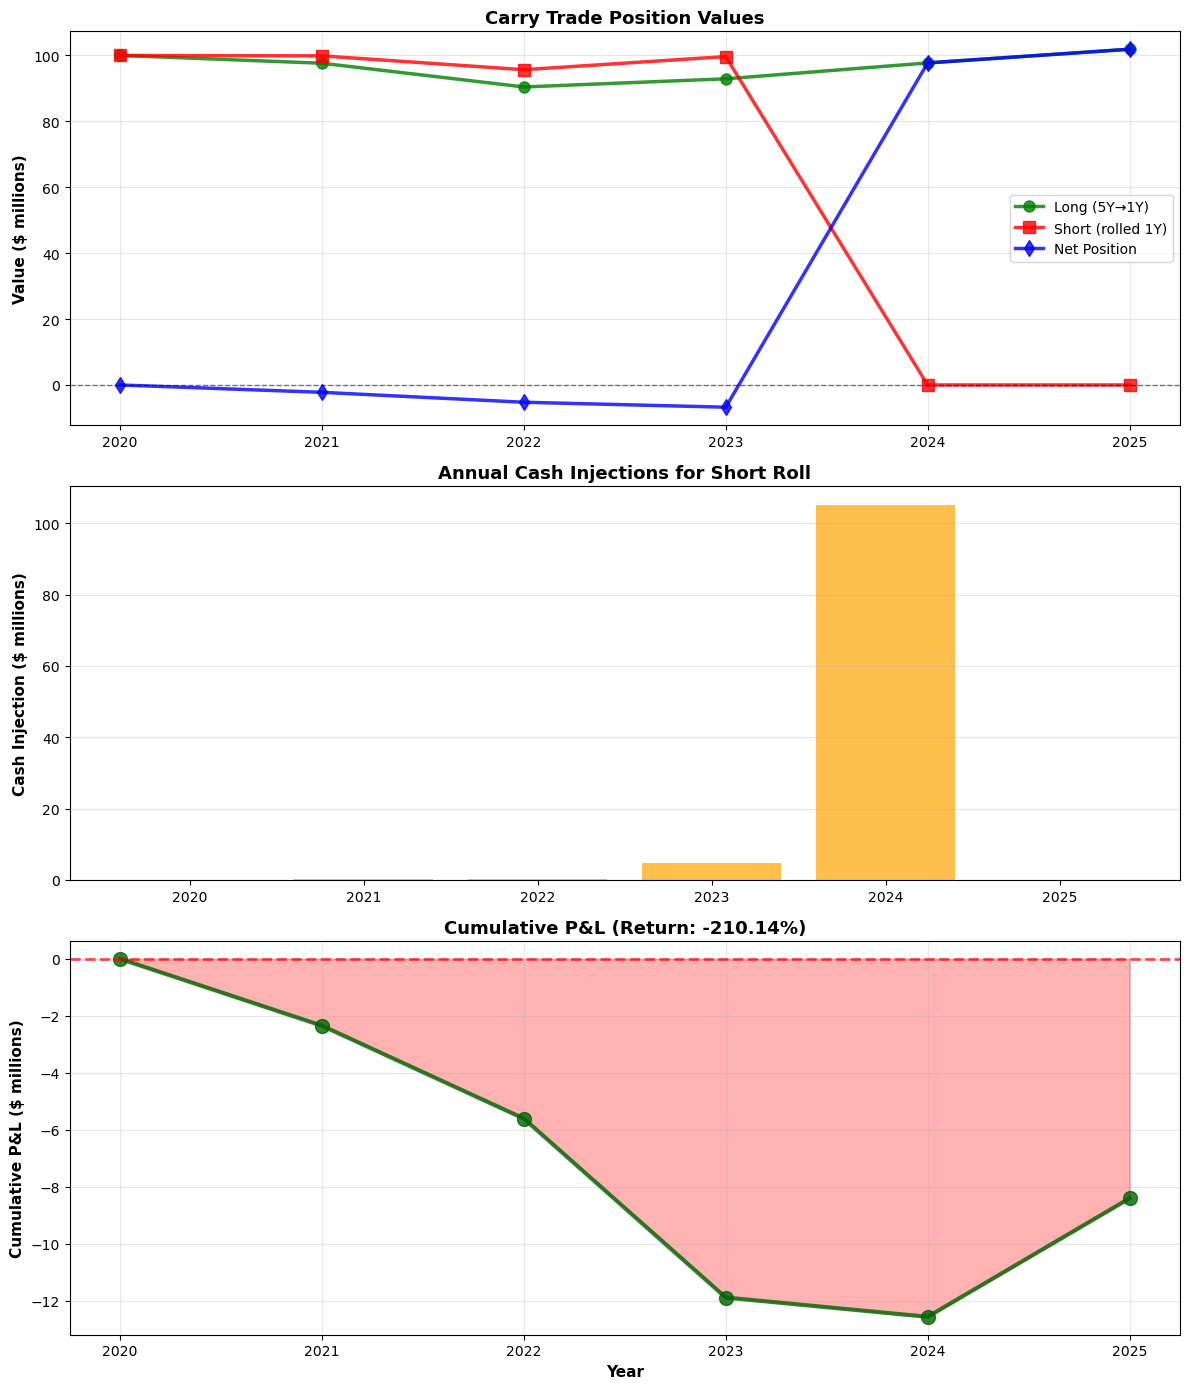

In [6]:
# Visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 14))

# Plot 1: Position values
axes[0].plot(pnl_df['year'], pnl_df['long_mtm']/1e6, 'o-', linewidth=2.5, markersize=8, 
             color='green', label='Long (5Y→1Y)', alpha=0.8)
axes[0].plot(pnl_df['year'], pnl_df['short_mtm']/1e6, 's-', linewidth=2.5, markersize=8, 
             color='red', label='Short (rolled 1Y)', alpha=0.8)
axes[0].plot(pnl_df['year'], pnl_df['net_mtm']/1e6, 'd-', linewidth=2.5, markersize=8, 
             color='blue', label='Net Position', alpha=0.8)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_ylabel('Value ($ millions)', fontsize=11, fontweight='bold')
axes[0].set_title('Carry Trade Position Values', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Cash injections
axes[1].bar(pnl_df['year'], pnl_df['cash_injection']/1e6, color='orange', alpha=0.7)
axes[1].set_ylabel('Cash Injection ($ millions)', fontsize=11, fontweight='bold')
axes[1].set_title('Annual Cash Injections for Short Roll', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Cumulative P&L
axes[2].plot(pnl_df['year'], pnl_df['cumulative_pnl']/1e6, 'o-', linewidth=3, 
             markersize=10, color='darkgreen', alpha=0.8)
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[2].fill_between(pnl_df['year'], 0, pnl_df['cumulative_pnl']/1e6, 
                      alpha=0.3, color='green' if final_pnl > 0 else 'red')
axes[2].set_xlabel('Year', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Cumulative P&L ($ millions)', fontsize=11, fontweight='bold')
axes[2].set_title(f'Cumulative P&L (Return: {return_on_initial*100:.2f}%)', 
                  fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 1.2 Forward Rate Scenario Analysis

### Forward Rate Hypothesis

The **forward rate** $f(0,t,t+1)$ implied by zero prices represents the market's break-even 1-year rate at time $t$:

$$f(0,t,t+1) = \frac{Z(0,t)}{Z(0,t+1)} - 1$$

### No-Arbitrage Condition

Consider two investment strategies:
1. Buy $(t+1)$-year zero at price $Z(0,t+1)$
2. Buy $t$-year zero at $Z(0,t)$, then reinvest at forward rate

No arbitrage requires:
$$Z(0,t+1) = Z(0,t) \times \frac{1}{1 + f(0,t,t+1)}$$

### Implication for Carry Trade

**If realized spot rates equal forward rates**, then:
- Carry trade earns ≈ 0 excess return (ignoring financing costs)
- Forward rates already price in expected rate changes
- Positive returns indicate rates rose less than forwards predicted
- Negative returns indicate rates rose more than forwards predicted

In [7]:
# Calculate implied forward rates from Nov 2020
forward_rates = {}
for t in range(1, 5):
    f = (strips_nov.loc[0, t] / strips_nov.loc[0, t+1]) - 1
    forward_rates[t] = f
    print(f"Nov {2020+t} → Nov {2021+t}: {f:.4f} ({f*100:.2f}%)")

Nov 2021 → Nov 2022: 0.0018 (0.18%)
Nov 2022 → Nov 2023: 0.0026 (0.26%)
Nov 2023 → Nov 2024: 0.0057 (0.57%)
Nov 2024 → Nov 2025: 0.0074 (0.74%)


In [9]:
# Construct hypothetical price path where spot rates = forward rates
hypothetical = pd.DataFrame()

for i in range(6):  # Years 2020-2025
    year = 2020 + i
    row = {'date': pd.Timestamp(f'{year}-11-30')}
    
    if i == 0:
        # Nov 2020: use actual prices
        for m in [1, 2, 3, 4, 5]:
            row[m] = strips_nov.loc[0, m]
    else:
        # Subsequent years: construct using forward rates
        # 1-year zero price = forward discount factor from year i-1 to i
        if i <= 4:
            # F(0, i-1, i) = Z(0,i) / Z(0,i-1)
            row[1] = strips_nov.loc[0, i] / strips_nov.loc[0, i-1] if i > 1 else strips_nov.loc[0, 1]
        else:
            row[1] = 1.0  # At maturity
        
        # Longer maturities roll down
        for maturity in range(2, 6):
            years_from_now = i + maturity - 1
            if years_from_now <= 5:
                # This is a (years_from_now)-year bond from Nov 2020 perspective
                # Rolling down: a 5-year becomes 4-year, etc.
                if i == 0:
                    row[maturity] = strips_nov.loc[0, maturity]
                else:
                    # Price relative to Nov 2020 + i perspective
                    row[maturity] = strips_nov.loc[0, years_from_now] / strips_nov.loc[0, i]
            else:
                row[maturity] = np.nan
    
    hypothetical = pd.concat([hypothetical, pd.DataFrame([row])], ignore_index=True)

print("Hypothetical prices (forward rate path):")
display(hypothetical)

# Re-run carry trade with forward path
pnl_forward = []
short_face_fwd = face_short_initial

for i in range(len(hypothetical)):
    year = int(hypothetical.loc[i, 'date'].year)
    years_remaining = 2025 - year
    
    # Long position MTM
    if years_remaining > 0:
        Z_long = hypothetical.loc[i, years_remaining]
        long_mtm = face_long * Z_long
    else:
        Z_long = 1.0
        long_mtm = face_long
    
    # Short position and roll
    cash_injection = 0
    if year <= 2023:
        Z_short = hypothetical.loc[i, 1]
        short_mtm = short_face_fwd * Z_short
        
        if year >= 2021:  # Short matures, roll it
            cash_outflow = short_face_fwd
            new_short_proceeds = market_value_short
            short_face_fwd = market_value_short / Z_short
            cash_injection = cash_outflow - new_short_proceeds
    
    elif year == 2024:  # Close short
        Z_short = 0
        short_mtm = 0
        cash_injection = short_face_fwd
        short_face_fwd = 0
    
    else:  # 2025
        Z_short = 0
        short_mtm = 0
    
    net_mtm = long_mtm - short_mtm
    pnl_forward.append({
        'year': year,
        'years_to_maturity': years_remaining,
        'net_mtm': net_mtm,
        'cash_injection': cash_injection
    })

fwd_df = pd.DataFrame(pnl_forward)
fwd_df['mtm_pnl'] = fwd_df['net_mtm'].diff().fillna(0)
fwd_df['period_pnl'] = fwd_df['mtm_pnl'] - fwd_df['cash_injection']
fwd_df['cumulative_pnl'] = fwd_df['period_pnl'].cumsum()

final_pnl_fwd = fwd_df['cumulative_pnl'].iloc[-1]
return_fwd = final_pnl_fwd / initial_capital

print(f"\nActual Path Return:   {return_on_initial:.2%}")
print(f"Forward Path Return:  {return_fwd:.2%}")
print(f"Difference:           {(return_on_initial - return_fwd)*100:.2f}%")

Hypothetical prices (forward rate path):


,date,1,2,3,4,5
0,2020-11-30,0.998839,0.997047,0.994464,0.988809,0.981515
1,2021-11-30,0.998839,0.998206,0.995620,0.989958,0.982656
2,2022-11-30,0.998206,0.997409,0.991738,0.984422,NaN
3,2023-11-30,0.997409,0.994314,0.986979,NaN,NaN
4,2024-11-30,0.994314,0.992624,NaN,NaN,NaN
5,2025-11-30,1.000000,NaN,NaN,NaN,NaN



Actual Path Return:   -210.14%
Forward Path Return:  30.28%
Difference:           -240.42%


## 1.3 Expectations Hypothesis: Fact 3

### Fact 3 Statement

**When the term spread (forward premium) is high, long-term bonds tend to earn positive excess returns over short-term bonds.**

### Mathematical Framework (Fama-Bliss 1987, Campbell-Shiller 1991)

Excess return on $n$-year bond over 1-year:
$$\text{Excess Return}_{t,t+1} = r_{t+1}^{(n-1)} - r_t^{(1)}$$

**Empirical finding**:
$$E_t[\text{Excess Return}_{t,t+1}] \approx \alpha + \beta \cdot [f_t^{(n)} - r_t^{(1)}]$$

where $\beta > 0$, meaning:
- **Steep curve** (high $f - r$) → Higher expected excess returns
- **Flat curve** (low $f - r$) → Lower expected excess returns

### Application to Carry Trade

The attractiveness of long 5Y / short 1Y trade depends on **term spread**:
$$\text{Term Spread} = r(t,5) - r(t,1)$$

Or equivalently, **forward premium**:
$$\text{Forward Premium} = f(t,4,5) - r(t,1)$$

**Prediction**: Higher spread in Nov 2025 vs Nov 2020 → More favorable 2025-2030 carry trade

In [10]:
# Compare term structures
def discount_to_rate(Z, n):
    return (1/Z)**(1/n) - 1

# Nov 2020
r_1y_2020 = discount_to_rate(strips_nov.loc[0, 1], 1)
r_5y_2020 = discount_to_rate(strips_nov.loc[0, 5], 5)
spread_2020 = r_5y_2020 - r_1y_2020
forward_5y_2020 = (strips_nov.loc[0, 4] / strips_nov.loc[0, 5]) - 1
premium_2020 = forward_5y_2020 - r_1y_2020

# Nov 2025
r_1y_2025 = discount_to_rate(strips_nov.loc[5, 1], 1)
r_5y_2025 = discount_to_rate(strips_nov.loc[5, 5], 5)
spread_2025 = r_5y_2025 - r_1y_2025
forward_5y_2025 = (strips_nov.loc[5, 4] / strips_nov.loc[5, 5]) - 1
premium_2025 = forward_5y_2025 - r_1y_2025

comparison = pd.DataFrame({
    'Metric': ['1Y Spot', '5Y Spot', 'Term Spread', '5Y Forward', 'Forward Premium'],
    'Nov 2020': [f"{r_1y_2020*100:.2f}%", f"{r_5y_2020*100:.2f}%", 
                 f"{spread_2020*100:.2f}%", f"{forward_5y_2020*100:.2f}%", f"{premium_2020*100:.2f}%"],
    'Nov 2025': [f"{r_1y_2025*100:.2f}%", f"{r_5y_2025*100:.2f}%", 
                 f"{spread_2025*100:.2f}%", f"{forward_5y_2025*100:.2f}%", f"{premium_2025*100:.2f}%"],
    'Change': [f"{(r_1y_2025-r_1y_2020)*100:+.2f}%", f"{(r_5y_2025-r_5y_2020)*100:+.2f}%",
               f"{(spread_2025-spread_2020)*100:+.2f}%", f"{(forward_5y_2025-forward_5y_2020)*100:+.2f}%",
               f"{(premium_2025-premium_2020)*100:+.2f}%"]
})

display(comparison)

,Metric,Nov 2020,Nov 2025,Change
0,1Y Spot,0.12%,3.63%,+3.52%
1,5Y Spot,0.37%,3.65%,+3.27%
2,Term Spread,0.26%,0.01%,-0.25%
3,5Y Forward,0.74%,3.85%,+3.11%
4,Forward Premium,0.63%,0.22%,-0.41%


## Conclusion: Fact 3 Prediction

In [11]:
if spread_2025 > spread_2020:
    print("✓ Nov 2025 curve is STEEPER → Carry trade looks MORE FAVORABLE")
    print(f"  Term spread increased by {(spread_2025-spread_2020)*10000:.0f} bps")
    print(f"  Expected excess return on 2025-2030 > 2020-2025")
else:
    print("✗ Nov 2025 curve is FLATTER → Carry trade looks LESS FAVORABLE")
    print(f"  Term spread decreased by {(spread_2020-spread_2025)*10000:.0f} bps")
    print(f"  Expected excess return on 2025-2030 < 2020-2025")

✗ Nov 2025 curve is FLATTER → Carry trade looks LESS FAVORABLE
  Term spread decreased by 25 bps
  Expected excess return on 2025-2030 < 2020-2025


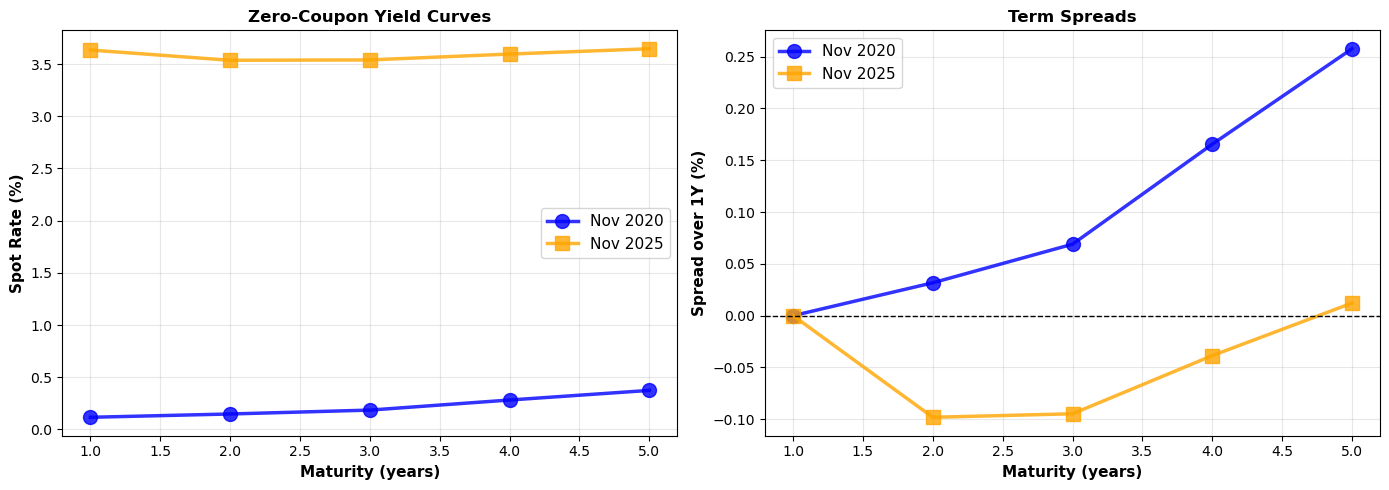

In [12]:
# Visualization: Yield curve comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

maturities = [1, 2, 3, 4, 5]
rates_2020 = [discount_to_rate(strips_nov.loc[0, m], m)*100 for m in maturities]
rates_2025 = [discount_to_rate(strips_nov.loc[5, m], m)*100 for m in maturities]

# Yield curves
axes[0].plot(maturities, rates_2020, 'o-', linewidth=2.5, markersize=10, 
             color='blue', label='Nov 2020', alpha=0.8)
axes[0].plot(maturities, rates_2025, 's-', linewidth=2.5, markersize=10, 
             color='orange', label='Nov 2025', alpha=0.8)
axes[0].set_xlabel('Maturity (years)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Spot Rate (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Zero-Coupon Yield Curves', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Term spreads
spreads_2020 = [rates_2020[i] - rates_2020[0] for i in range(5)]
spreads_2025 = [rates_2025[i] - rates_2025[0] for i in range(5)]

axes[1].plot(maturities, spreads_2020, 'o-', linewidth=2.5, markersize=10, 
             color='blue', label='Nov 2020', alpha=0.8)
axes[1].plot(maturities, spreads_2025, 's-', linewidth=2.5, markersize=10, 
             color='orange', label='Nov 2025', alpha=0.8)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_xlabel('Maturity (years)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Spread over 1Y (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Term Spreads', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2.1 Forward Discount Factors

### Definition

The **forward discount factor** from time $T_1$ to $T_2$ observed at time $t$ is:

$$F(t, T_1, T_2) = \frac{Z(t, T_2)}{Z(t, T_1)}$$

This represents the price at time $t$ for a contract that delivers a zero-coupon bond maturing at $T_2$ at time $T_1$.

### Relationship to Forward Rates

The forward discount factor relates to the forward rate $f(t, T_1, T_2)$ via:

$$F(t, T_1, T_2) = \frac{1}{1 + f(t, T_1, T_2) \cdot (T_2 - T_1)}$$

For 1-year forwards ($T_2 - T_1 = 1$):

$$f(t, T_1, T_2) = \frac{1}{F(t, T_1, T_2)} - 1$$

### Time Evolution

Observing how $F(t, T_1, T_2)$ changes across different $t$ reveals:
- Market expectations about future rates
- Term premium evolution
- Realized vs. expected rate paths

In [13]:
# Calculate forward discount factors for all dates
forward_data = []

for i in range(len(strips_nov)):
    date = strips_nov.loc[i, 'date']
    year = date.year
    
    for T1 in range(1, 5):  # T1 = 1, 2, 3, 4
        T2 = T1 + 1
        
        Z_T1 = strips_nov.loc[i, T1]
        Z_T2 = strips_nov.loc[i, T2]
        
        # Forward discount factor
        F = Z_T2 / Z_T1
        
        # Implied forward rate
        f = (1 / F) - 1
        
        forward_data.append({
            'date': date,
            'year': year,
            'T1': T1,
            'T2': T2,
            'Z_T1': Z_T1,
            'Z_T2': Z_T2,
            'forward_discount': F,
            'forward_rate': f
        })

forward_df = pd.DataFrame(forward_data)

# Display table for each date
print("Forward Discount Factors F(t, T1, T2):")
print("="*70)
for year in range(2020, 2026):
    year_data = forward_df[forward_df['year'] == year]
    print(f"\nNovember {year}:")
    for _, row in year_data.iterrows():
        print(f"  F({year}, {row['T1']}, {row['T2']}) = {row['forward_discount']:.6f}  "
              f"[f = {row['forward_rate']*100:.4f}%]")

Forward Discount Factors F(t, T1, T2):

November 2020:
  F(2020, 1, 2) = 0.998206  [f = 0.1797%]
  F(2020, 2, 3) = 0.997409  [f = 0.2597%]
  F(2020, 3, 4) = 0.994314  [f = 0.5719%]
  F(2020, 4, 5) = 0.992624  [f = 0.7431%]

November 2021:
  F(2021, 1, 2) = 0.991069  [f = 0.9011%]
  F(2021, 2, 3) = 0.986023  [f = 1.4175%]
  F(2021, 3, 4) = 0.983100  [f = 1.7190%]
  F(2021, 4, 5) = 0.984817  [f = 1.5417%]

November 2022:
  F(2022, 1, 2) = 0.962116  [f = 3.9375%]
  F(2022, 2, 3) = 0.966661  [f = 3.4489%]
  F(2022, 3, 4) = 0.965918  [f = 3.5285%]
  F(2022, 4, 5) = 0.968784  [f = 3.2221%]

November 2023:
  F(2023, 1, 2) = 0.958858  [f = 4.2907%]
  F(2023, 2, 3) = 0.961627  [f = 3.9904%]
  F(2023, 3, 4) = 0.960356  [f = 4.1280%]
  F(2023, 4, 5) = 0.961038  [f = 4.0541%]

November 2024:
  F(2024, 1, 2) = 0.960108  [f = 4.1550%]
  F(2024, 2, 3) = 0.961470  [f = 4.0074%]
  F(2024, 3, 4) = 0.960447  [f = 4.1182%]
  F(2024, 4, 5) = 0.961639  [f = 3.9891%]

November 2025:
  F(2025, 1, 2) = 0.96676

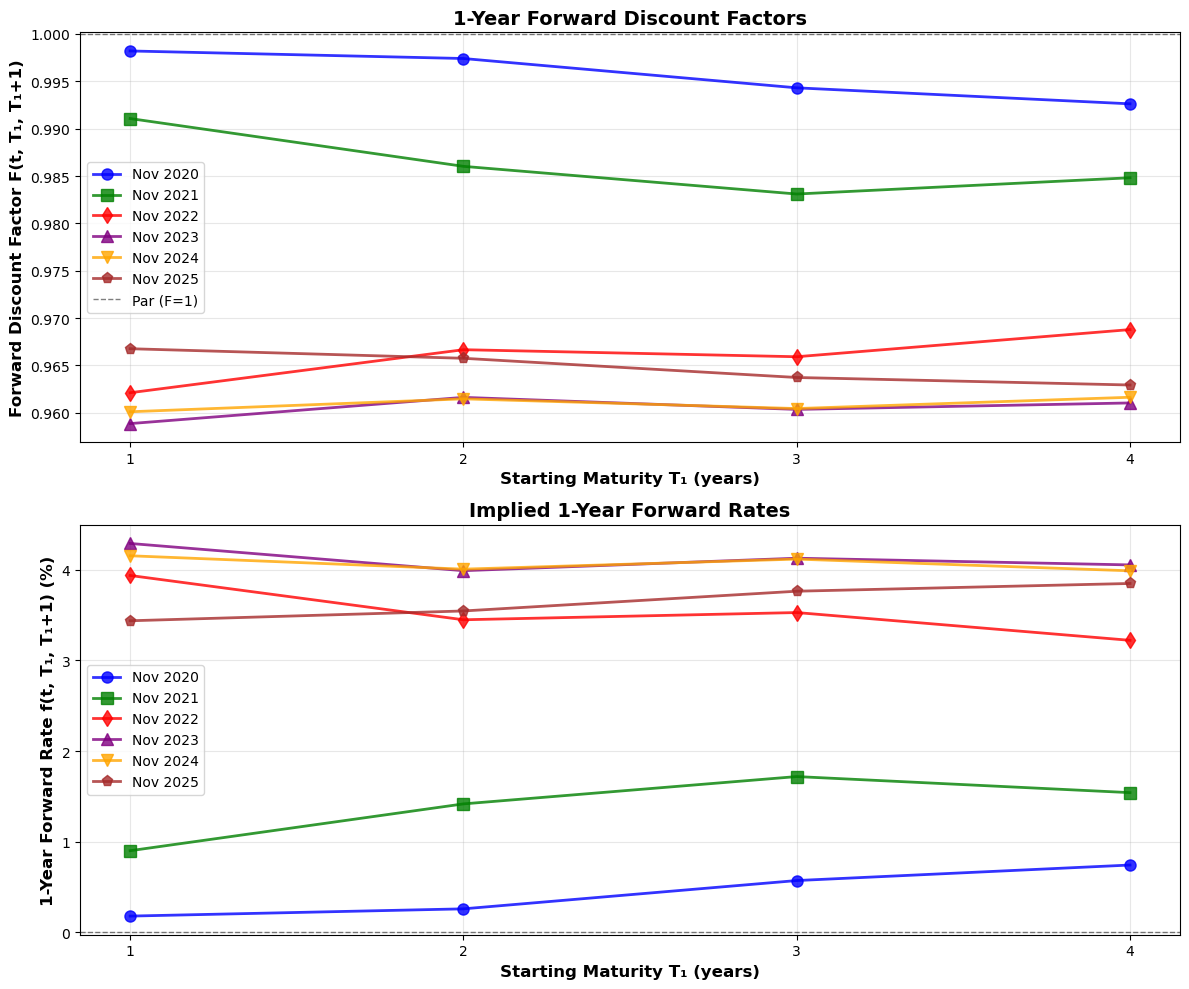

In [14]:
# Plot forward discount factor curves
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Forward Discount Factors
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
markers = ['o', 's', 'd', '^', 'v', 'p']

for i, year in enumerate(range(2020, 2026)):
    year_data = forward_df[forward_df['year'] == year]
    axes[0].plot(year_data['T1'], year_data['forward_discount'], 
                 marker=markers[i], linestyle='-', linewidth=2, markersize=8,
                 color=colors[i], label=f'Nov {year}', alpha=0.8)

axes[0].axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Par (F=1)')
axes[0].set_xlabel('Starting Maturity T₁ (years)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Forward Discount Factor F(t, T₁, T₁+1)', fontsize=12, fontweight='bold')
axes[0].set_title('1-Year Forward Discount Factors', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks([1, 2, 3, 4])

# Plot 2: Implied Forward Rates
for i, year in enumerate(range(2020, 2026)):
    year_data = forward_df[forward_df['year'] == year]
    axes[1].plot(year_data['T1'], year_data['forward_rate'] * 100, 
                 marker=markers[i], linestyle='-', linewidth=2, markersize=8,
                 color=colors[i], label=f'Nov {year}', alpha=0.8)

axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Starting Maturity T₁ (years)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('1-Year Forward Rate f(t, T₁, T₁+1) (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Implied 1-Year Forward Rates', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks([1, 2, 3, 4])

plt.tight_layout()
plt.show()

In [15]:
# Create a summary table showing evolution over time
pivot_forward = forward_df.pivot_table(
    values='forward_discount',
    index='year',
    columns='T1',
    aggfunc='first'
)
pivot_forward.columns = [f'F(t,{t},{t+1})' for t in pivot_forward.columns]

print("\nForward Discount Factors by Year:")
display(pivot_forward.style.format("{:.6f}"))

# Calculate changes over time
print("\nChange in Forward Discount Factors (2025 - 2020):")
changes = pivot_forward.loc[2025] - pivot_forward.loc[2020]
for col in changes.index:
    print(f"  Δ{col}: {changes[col]:+.6f}")


Forward Discount Factors by Year:


,"F(t,1,2)","F(t,2,3)","F(t,3,4)","F(t,4,5)"
year,,,,
2020,0.998206,0.997409,0.994314,0.992624
2021,0.991069,0.986023,0.983100,0.984817
2022,0.962116,0.966661,0.965918,0.968784
2023,0.958858,0.961627,0.960356,0.961038
2024,0.960108,0.961470,0.960447,0.961639
2025,0.966765,0.965755,0.963726,0.962934



Change in Forward Discount Factors (2025 - 2020):
  ΔF(t,1,2): -0.031441
  ΔF(t,2,3): -0.031655
  ΔF(t,3,4): -0.030587
  ΔF(t,4,5): -0.029690
